# 実習10-2 画像分類4（転移学習）

今回は、転移学習によって、VGGやMobileNetに基づいたモデルを作成し、
猫と犬の画像を分類するプログラムを作成する。

基本的な流れは以下のようになる。
*   元になるモデルを作成し、事前トレーニング済みの重みを読み込む。
*   trainable = False を設定して、ベースモデルのすべての層を凍結する
*   出力したいものを考慮し、ベースモデルに層を追加して新しいモデルを作成する。
*   新しいデータセットで新しいモデルをトレーニングする。

## 1. データセットの準備（共通）
前回までと同様に、犬と猫の画像データセットを使用する。

### 1-1. zipファイルのダウンロードと展開
犬と猫の画像データセットをダウンロードして展開する。実習09-2のプログラムをコピーして実施してよい。

In [1]:
# 必要に応じてimport文を書く
import tensorflow as tf
from tensorflow import keras

In [2]:
#画像サイズ（実行しておく）：今回は元モデルの入力が224x224のため
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [3]:
# ダウンロード元URL
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# get_fileを使用してzipをダウンロードし展開（import tensorflow as tf必要）
# ダウンロード先（cache_subdir）は必要に応じて変更する
path_to_zip = keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True, cache_subdir='/content/datasets')

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### 1-2. ImageDataGeneratorによるデータセットの作成
ImageDataGeneratorのセットアップ部分をコピーして実施する。訓練用と検証用のものをそれぞれ作成すること。

In [4]:
# ImageDataGeneratorのセットアップ
from tensorflow.keras.preprocessing.image import ImageDataGenerator

次に、flow_from_directoryを使用し、画像のあるディレクトリ等を指定する。すると、データセットを自動的に作成する。訓練用と検証用のデータセットをそれぞれ作成すること。
**seedには学籍番号を指定すること。**

In [5]:
# 訓練用
train_img_gen = ImageDataGenerator(rescale=1./255)
train_data_it = train_img_gen.flow_from_directory(directory='/content/datasets/cats_and_dogs_filtered/train',
                                                           shuffle=True, #シャッフルするか
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH), #出力画像ファイル
                                                           class_mode='binary', # ラベル（出力）の種類
                                                           seed=2220042)

Found 2000 images belonging to 2 classes.


In [19]:
# テスト用
val_img_gen = ImageDataGenerator(rescale=1./255)
val_data_it = val_img_gen.flow_from_directory(directory='/content/datasets/cats_and_dogs_filtered/validation',
                                                           shuffle=True, #シャッフルするか
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH), #出力画像ファイル
                                                           class_mode='binary', # ラベル（出力）の種類
                                                           seed=2220042)

Found 1000 images belonging to 2 classes.


## 2. VGG16を利用した転移学習（練習用）

### 2-1. VGG16モデルの形状確認
まずは、今回使用するVGG16の本来のモデル形状を確認する。モデルを作成してsummary()で表示してみよう。

[参考：VGG16](https://keras.io/ja/applications/#vgg16)

```
# VGGを使用するためにimport
from keras.applications.vgg16 import VGG16

# モデルの作成（仮）
model_org = VGG16()

# summaryの確認
model_org.summary()

```

In [7]:
# VGGを使用するためにimport
from keras.applications.vgg16 import VGG16

In [8]:
# モデルの作成
model_org = VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [9]:
# summaryの確認
model_org.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

**出力層のノード数はいくつになっていますか？[　1000　]**

### 2-2. VGG16を転移学習用に読み込み

VGG16は転移学習に使用されることも多い。この場合は、モデル作成時に引数としてinclude_top=Falseを指定する。

また、重みパラメータはImageNetで学習済みのものを読み込む。
```
# VGG16を転移学習のベースモデルとして読み込み
# 入力の形状を変更することもできるが、今回はモデル作成時に追加しておく
base_model = VGG16(weights='imagenet',input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),include_top=False)

# base_modelのサマリを表示
base_model.summary()

```


In [10]:
# VGG16を転移学習のベースモデルとして読み込み
base_model = VGG16(weights='imagenet',input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
# base_modelのサマリを表示
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**元のVGG16のモデルと、ここで作成したモデルの違いは何ですか？<br>
[　flatten 以降の層がなくなってる　]**

上記summaryでは、すべてのパラメータがTrainable（学習可能）になっている。
転移学習を行う場合、途中の重みは学習済みのものに固定しておくため、学習を不可にしておく。
```
# モデルの凍結
base_model.trainable = False
# summaryの確認
base_model.summary()
```


In [12]:
#モデルの凍結
base_model.trainable = False

In [13]:
# summaryの確認
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

**パラメータがすべてTrainableからNon-Trainableになっていることを確認すること。**

### 2-3. 新しいモデルの作成
上で作成したベースモデルに層を追加して新しいモデルを作成する。今回は、入力の形状を指定し、後半にFlatten（1次元にする）、全結合層、出力層を追加しよう。

（Functional APIでないと作れないかもしれない）

```
# 短く書くためにインポート
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

# 入力層を作成する
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# ベースモデルに層を追加する。
x = base_model(inputs)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(出力ノード数, activation='出力の活性化関数')(x)

# Modelの引数として入力（inputs）と出力（outputs）を指定してモデルを作成する
model = Model(inputs=inputs, outputs=predictions)

# summaryを表示して確認
model.summary()

```

In [14]:
# 短く書くためにインポート
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

In [15]:
# 入力層を作成する
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# ベースモデルに層を追加する。
x = base_model(inputs)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Modelの引数として入力（inputs）と出力（outputs）を指定してモデルを作成する
model = Model(inputs=inputs, outputs=predictions)


In [16]:
# summaryを表示して確認
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,320,449 (62.26 MB)

 Trainable params: 1,605,761 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 2-4. 新しいデータで学習
VGG16を使用して作成したモデルを、学習させたいデータ（犬と猫）で学習させる。

```
# モデルのコンパイル
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fitで学習しつつ検証（とりあえずepochs=5で）
hist = model.fit(train_data_it,validation_data= val_data_it, epochs=5)
```

In [17]:
#モデルのコンパイル
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
# fitで学習しつつ検証
hist = model.fit(train_data_it,validation_data= val_data_it, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 392ms/step - accuracy: 0.5814 - loss: 1.0399 - val_accuracy: 0.8880 - val_loss: 0.3347
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.8905 - loss: 0.2948 - val_accuracy: 0.8770 - val_loss: 0.2938
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.9348 - loss: 0.2015 - val_accuracy: 0.9030 - val_loss: 0.2322
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.9563 - loss: 0.1416 - val_accuracy: 0.9060 - val_loss: 0.2198
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - accuracy: 0.9748 - loss: 0.1016 - val_accuracy: 0.9110 - val_loss: 0.2086


※今回はエポック数が少ないので、グラフでなく数値で確認してもよい。<br />
（グラフを描いてみてもよいです。）

### 2-5. 画像の判定
実際に画像を判定してみよう。画像をアップロードしてもよいし、テストデータの中から選んでもよい（以前の実習を参照）



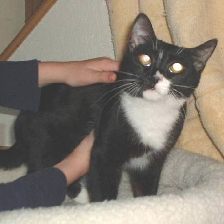

In [29]:
#猫の画像
#読み込みと確認
img_c = keras.preprocessing.image.load_img(
    '/content/datasets/cats_and_dogs_filtered/validation/cats/cat.2000.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_c

In [30]:
# 画像を配列に変換
img_array = keras.preprocessing.image.img_to_array(img_c)
# 軸の追加（1枚の画像のため）
img_array = img_array[tf.newaxis, ...]
# スケーリング（0～255 → 0～1）
img_array = img_array/255.0

In [62]:
# 手順例（この通りでなくても可）
# 予測結果を一旦変数に入れる
pred = model.predict(img_array)
# 四捨五入しint型に変換
pred = model.predict(img_array).round().astype(int)

# 変換リストの作成
list(train_data_it.class_indices.keys())

# リスト名[0か1]
list(train_data_it.class_indices.keys())[pred[0][0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'cats'

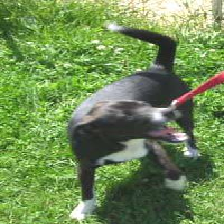

In [32]:
#犬の画像
#読み込みと確認
img_d = keras.preprocessing.image.load_img(
    '/content/datasets/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_d

In [33]:
# 画像を配列に変換
img_array2 = keras.preprocessing.image.img_to_array(img_d)
# 軸の追加（1枚の画像のため）
img_array2 = img_array2[tf.newaxis, ...]
# スケーリング（0～255 → 0～1）
img_array2 = img_array2/255.0

In [63]:
# 手順例（この通りでなくても可）
# 予測結果を一旦変数に入れる
pred = model.predict(img_array2)
# 四捨五入しint型に変換
pred = model.predict(img_array2).round().astype(int)

# 変換リストの作成
list(train_data_it.class_indices.keys())

# リスト名[0か1]
list(train_data_it.class_indices.keys())[pred[0][0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'dogs'

## 3. MobileNetを使用した転移学習（実習用）

### 3-1. MobileNetモデルの形状確認
まずは、今回使用するMobileNetの本来のモデル形状を確認する。モデルを作成してsummary()で表示してみよう。

[参考：MobileNet](https://keras.io/ja/applications/#mobilenet)

```
#  MobileNetを使用するためにimport
from tensorflow.keras.applications.mobilenet import MobileNet

# モデルの作成
model_org2 = ...

# summaryの確認
model_org2.summary()

```

In [64]:
#  MobileNetを使用するためにimport
from tensorflow.keras.applications.mobilenet import MobileNet

# モデルの作成
model_org2 = MobileNet()

# summaryの確認
model_org2.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

### 3-2. MobileNetを転移学習用に読み込み

MobileNetを転移学習用に読み込む場合は、この場合は、モデル作成時に引数としてinclude_top=Falseを指定する。

また、重みパラメータはImageNetで学習済みのものを読み込む。
```
# MobileNetを転移学習のベースモデルとして読み込み
base_model2 = ...

# base_model2のサマリを表示
base_model2.summary()
```

In [65]:
# MobileNetを転移学習のベースモデルとして読み込み
base_model2 = MobileNet(weights='imagenet', include_top=False)

# base_model2のサマリを表示
base_model2.summary()

<ipython-input-65-22884f589642>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model2 = MobileNet(weights='imagenet', include_top=False)


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, None, None, 32)      │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, None, None, 32)      │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, None, None, 64)      │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, None, None, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, None, None, 64)      │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, None, None, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, None, None, 128)     │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, None, None, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, None, None, 128)     │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, None, None, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, None, None, 128)     │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

上記summaryとベースモデルの違いを確認しておく。

また、多くのパラメータがTrainable（学習可能）になっているので、学習を不可にしておく。
```
# モデルの凍結
base_model2.trainable = ...
# summaryの確認
base_model2.summary()
```

In [66]:
# モデルの凍結
base_model2.trainable = False

# summaryの確認
base_model2.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, None, None, 32)      │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, None, None, 32)      │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, None, None, 64)      │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, None, None, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, None, None, 64)      │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, None, None, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, None, None, 128)     │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, None, None, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, None, None, 128)     │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, None, None, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, None, None, 128)     │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

**パラメータがすべてTrainableからNon-Trainableになっていることを確認すること。**

### 3-3. 新しいモデルの作成
上で作成したベースモデルに層を追加して新しいモデルを作成する。今回は、入力の形状を指定し、後半にFlatten（1次元にする）、全結合層、出力層を追加してみよう。

（Functional APIでないと作れないかもしれない）

```
# 短く書くためにインポート
from keras.layers import Input, Flatten, Dense
from keras.models import Model

# 入力層を作成する

# ベースモデルに層を追加する。

# Modelの引数として入力（inputs）と出力（outputs）を指定してモデルを作成する

# summaryを表示して確認


```

In [67]:
# 短く書くためにインポート
from keras.layers import Input, Flatten, Dense
from keras.models import Model

# 入力層を作成する
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# ベースモデルに層を追加する。
x = base_model2(inputs)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Modelの引数として入力（inputs）と出力（outputs）を指定してモデルを作成する
model2 = Model(inputs=inputs, outputs=predictions)


### 3-4. 新しいデータで学習
MobileNetを使用して作成したモデルを、学習させたいデータ（犬と猫）で学習させる。

```
# モデルのコンパイル
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fitで学習しつつ検証（とりあえずepochs=5で）
hist2 = model2.fit(train_data_it,validation_data= val_data_it, epochs=5)
```

In [68]:
# モデルのコンパイル
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fitで学習しつつ検証（とりあえずepochs=5で）
hist2 = model2.fit(train_data_it,validation_data= val_data_it, epochs=5)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.9250 - loss: 0.8114 - val_accuracy: 0.9700 - val_loss: 0.5261
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.9838 - loss: 0.2180 - val_accuracy: 0.9660 - val_loss: 0.6971
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.9932 - loss: 0.0720 - val_accuracy: 0.9860 - val_loss: 0.2116
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.9963 - loss: 0.0410 - val_accuracy: 0.9830 - val_loss: 0.1858
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9957 - loss: 0.0855 - val_accuracy: 0.9840 - val_loss: 0.3299


※今回はエポック数が少ないので、グラフでなく数値で確認してもよい。<br />
（グラフを描いてみてもよいです。）

### 3-5. 画像の判定
実際に画像を判定してみよう。画像をアップロードしてもよいし、テストデータの中から選んでもよい

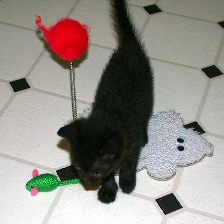

In [72]:
#猫の画像
#読み込みと確認
img_c2 = keras.preprocessing.image.load_img(
    '/content/datasets/cats_and_dogs_filtered/validation/cats/cat.2002.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_c2

In [73]:
# 画像を配列に変換
img_array3 = keras.preprocessing.image.img_to_array(img_c2)
# 軸の追加（1枚の画像のため）
img_array3 = img_array3[tf.newaxis, ...]
# スケーリング（0～255 → 0～1）
img_array3 = img_array3/255.0

In [75]:
# 手順例（この通りでなくても可）
# 予測結果を一旦変数に入れる
pred = model2.predict(img_array3)
# 四捨五入しint型に変換
pred = model2.predict(img_array3).round().astype(int)

# 変換リストの作成
list(train_data_it.class_indices.keys())

# リスト名[0か1]
list(train_data_it.class_indices.keys())[pred[0][0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'cats'

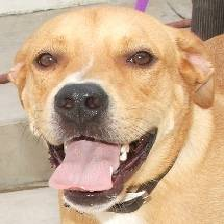

In [48]:
#犬の画像
#読み込みと確認
img_d2 = keras.preprocessing.image.load_img(
    '/content/datasets/cats_and_dogs_filtered/validation/dogs/dog.2001.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_d2

In [55]:
# 画像を配列に変換
img_array4 = keras.preprocessing.image.img_to_array(img_d2)
# 軸の追加（1枚の画像のため）
img_array4 = img_array4[tf.newaxis, ...]
# スケーリング（0～255 → 0～1）
img_array4 = img_array4/255.0

In [76]:
# 手順例（この通りでなくても可）
# 予測結果を一旦変数に入れる
pred = model2.predict(img_array4)
# 四捨五入しint型に変換
pred = model2.predict(img_array4).round().astype(int)

# 変換リストの作成
list(train_data_it.class_indices.keys())

# リスト名[0か1]
list(train_data_it.class_indices.keys())[pred[0][0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'dogs'

# 提出について

実習が終わったら、以下を教員にチェックしてもらうこと。

*   MobileNetを使用した転移学習の学習結果
*   猫と犬の画像の予測結果

このファイルをipynbでダウンロードして提出してください。（ファイル名にクラス番号氏名を入れること。）
